In [1]:
from pyvi.pyvi import ViTokenizer, ViPosTagger
from sklearn.base import TransformerMixin, BaseEstimator
import os
from sklearn.svm import LinearSVC
from gensim import corpora, matutils
from sklearn.metrics import classification_report
import sys
import codecs
import json
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DIR_PATH="/Users/mac/Downloads/Data"
DIR_PATH_TRAIN = os.path.join(DIR_PATH,'Train_Full')
DIR_PATH_TEST = os.path.join(DIR_PATH,'Test_Full')
DICTIONARY_PATH = os.path.join(DIR_PATH,'dictionary.txt')
STOP_WORDS = os.path.join(DIR_PATH,'stopwords-nlp-vi.txt')
SPECIAL_CHARACTER = '0123456789?…“”–%@$.,=+-!;/()*"&^:#|\n\t\''
print(STOP_WORDS)
label=['Van hoa','The gioi','Khoa hoc','Suc khoe','Chinh tri Xa hoi',
       'Vi tinh','Kinh doanh','The thao','Phap luat','Doi song']

/Users/mac/Downloads/Data/stopwords-nlp-vi.txt


In [3]:
class ReadData(object):
    def __init__(self,dataPath,encoder=None):
        self.dataPath = dataPath
        self.encoder = encoder if encoder != None else 'utf-16le'
        
    def get_name_files(self):
        class_file = os.listdir(self.dataPath)        
        class_label=[]
        folders=[]
        for file in os.listdir(self.dataPath):
            class_label.append(file)
            folders.append(os.path.join(self.dataPath,file))
        self.folders = folders
        self.class_label=class_label
        #print(self.class_label)
        #print (self.folders)
        
    def get_data(self):
        self.get_name_files()
        data=[]
        i=0
        for label in self.class_label:
            rand = random.randint(50,100)
            print(label)
            for file in os.listdir(self.folders[self.class_label.index(label)]):
                #print(file)
                i+=1
                with open(os.path.join(self.folders[self.class_label.index(label)],file),'rb') as f:
                    s = f.read()                  
                data.append({
                    "label":label,
                    "content":s.decode(self.encoder) 
                })
                if(i==rand): break
            i=0
            #if(i>100): break
        self.data=data
        print(len(data))
        return data
    
    def read_stopwords(self):
        with open(self.dataPath, 'r') as f:
            stopwords = set([w.strip().replace(' ', '_') for w in f.readlines()])
        return stopwords
    
    def load_dictionary(self):
        return corpora.Dictionary.load_from_text(self.dataPath)          

In [4]:
class FileStore(object):
    def __init__(self, filePath, data = None):
        self.filePath = filePath
        self.data = data

    def store_dictionary(self, dict_words):
        dictionary = corpora.Dictionary(dict_words)
        #dictionary.filter_extremes(no_below=1, no_above=0.1)
        dictionary.filter_extremes(no_below=20, no_above=0.3)
        dictionary.save_as_text(self.filePath)

    def save_model(self,  obj):
        outfile = open(self.filePath, 'wb')
        fastPickler = cPickle.Pickler(outfile, cPickle.HIGHEST_PROTOCOL)
        fastPickler.fast = 1
        fastPickler.dump(obj)
        outfile.close()

In [5]:
class FeatureExtraction(object):
    def __init__(self, data):
        self.data = data

    def __build_dictionary(self):
        print ('Building dictionary')
        dict_words = []
        i = 0
        for text in self.data:
            i+=1
            #print ("Step {} / {}".format(i, len(self.data)))
            words = NLP(text=text['content']).get_words_feature()
            dict_words.append(words)
        FileStore(filePath=DICTIONARY_PATH).store_dictionary(dict_words)

    def __load_dictionary(self):
        if os.path.exists(DICTIONARY_PATH) == False:
            self.__build_dictionary()
        self.dictionary = ReadData(DICTIONARY_PATH).load_dictionary()

    def build_dataset(self):
        self.features = []
        self.labels = []
        i = 0
        for d in self.data:
            i += 1
            #print ("Step {} / {}".format(i, len(self.data)))
            self.features.append(self.get_dense(d['content']))
            self.labels.append(label.index(d['label']))
            #self.labels.append(d['label'])

    def get_dense(self, text):
        self.__load_dictionary()
        words = NLP(text).get_words_feature()
        i=0
        #print(words)
        # Bag of words
        vec = self.dictionary.doc2bow(words)
        dense = list(matutils.corpus2dense([vec], num_terms=len(self.dictionary)).T[0])
        #return words,len(self.dictionary)
        return dense

    def get_data_and_label(self):
        self.build_dataset()
        return self.features, self.labels

In [6]:
class NLP(object):
    def __init__(self, text = None):
        self.text = text
        self.__set_stopwords()

    def segmentation(self):
        return ViTokenizer.tokenize(self.text)
    
    def display(self):
        print(self.segmentation())
        
    def __set_stopwords(self):
        self.stopwords = ReadData(STOP_WORDS).read_stopwords()
        
    def split_words(self):
        text = self.segmentation()
        try:
            return [x.strip(SPECIAL_CHARACTER).lower() for x in text.split()]
        except TypeError:
            return []
        
    def get_words_feature(self):
        split_words = self.split_words()
        return [word for word in split_words if word.encode('utf-8') not in self.stopwords]

In [7]:
read_train = ReadData(DIR_PATH_TRAIN)
data_train = read_train.get_data()
read_test = ReadData(DIR_PATH_TEST)
data_test = read_test.get_data()
#data_train,label_train = FeatureExtraction(data=data_train).get_data_and_label()
x_train,y_train = FeatureExtraction(data=data_train).get_data_and_label()
x_test,y_test = FeatureExtraction(data=data_test).get_data_and_label()

Van hoa
The gioi
Khoa hoc
Suc khoe
Chinh tri Xa hoi
Vi tinh
Kinh doanh
The thao
Phap luat
Doi song
718
Van hoa
The gioi
Khoa hoc
Suc khoe
Chinh tri Xa hoi
Vi tinh
Kinh doanh
The thao
Phap luat
Doi song
820
Building dictionary


In [8]:
y_train = np.asarray(y_train)
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train = onehot_encoder.fit_transform(y_train)
print(y_train.shape)

y_test = np.asarray(y_test)
onehot_encoder = OneHotEncoder(sparse=False)
y_test = y_test.reshape(len(y_test), 1)
y_test = onehot_encoder.fit_transform(y_test)
print(y_test.shape)

(718, 10)
(820, 10)


In [9]:
x_train = np.asarray(x_train)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test=np.asarray(x_test)
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])
print(x_train.shape)
print(x_test.shape)

(718, 1077)
(820, 1077)


In [10]:
train_numbers = np.random.choice(x_train.shape[0],round(x_train.shape[0]*0.8),replace=False)
valid_numbers = np.array(list(set(range(x_train.shape[0])) - set(train_numbers)))
# train_numbers = np.random.choice(len(data_train),round(len(data_train)*0.8),replace=False)
# valid_numbers = np.array(list(set(range(len(data_train))) - set(train_numbers)))
print(train_numbers.shape)
print(valid_numbers.shape)

x_valid = x_train[valid_numbers]
x_train= x_train[train_numbers]
y_valid = y_train[valid_numbers]
y_train = y_train[train_numbers]

# x_train = list(data_train[i] for i in train_numbers )
# x_valid = list(data_train[i] for i in valid_numbers )
# y_train = list(label_train[i] for i in train_numbers )
# y_valid = list(label_train[i] for i in valid_numbers )

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)
# print(len(x_train))
# print(len(y_train))

(574,)
(144,)
(574, 1077)
(144, 1077)
(574, 10)
(144, 10)


In [11]:
sess = tf.Session()
#feature_size = x_train.shape[1]
# graph = tf.Graph()
# with graph.as_default():
delta = 1.0
regulation_rate = 0
learn_rate = 0

x_data = tf.placeholder(shape=[None,x_train.shape[1]], dtype=tf.float32)
y_data = tf.placeholder(shape=[None,y_train.shape[1]], dtype=tf.float32)    
W = tf.Variable(tf.random_normal(shape=[x_train.shape[1], y_train.shape[1]]))
    
predict = tf.matmul(x_data,W)
y = tf.reduce_sum(predict*y_data, 1, keep_dims=True)
loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, delta - y + predict),1))
loss = tf.add(loss,regulation_rate * tf.nn.l2_loss(W))

prediction = tf.argmax(predict,1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_data,1)), tf.float32))

# Declare optimizer
my_opt = tf.train.AdamOptimizer(learning_rate=learn_rate)
train_step = my_opt.minimize(loss)

# Initialize variables
# init = tf.global_variables_initializer()
# sess.run(init)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
batch_size = 30
delta = 1.0
learning_rates = [0.01,0.015]
regularization_strengths = [4e-4, 8e-4]
loss_best=1000
num_iters =1501
#sess.run(tf.initialize_all_variables())
for lr in learning_rates:
    learning_rates = lr 
    for reg in regularization_strengths:
        train_loss = []
        valid_loss = []
        train_accuracy = []
        valid_accuracy = []
        sess.run(tf.initialize_all_variables())
        #tf.reset_default_graph()
        regulation_rate = reg
        for i in range(num_iters):
            rand_index = np.random.choice(x_train.shape[0], size=batch_size)
            rand_x = x_train[rand_index]
            rand_y = y_train[rand_index,:]
            sess.run(train_step, feed_dict={x_data: rand_x, y_data: rand_y})

            tloss = sess.run(loss, feed_dict={x_data: rand_x, y_data: rand_y})
            train_loss.append(tloss)   
    
            train_acc_temp = sess.run(accuracy, feed_dict={
                x_data: x_train,
                y_data: y_train})
            train_accuracy.append(train_acc_temp)
            
            Weight = sess.run(W)
            vloss = sess.run(loss, feed_dict={x_data: x_valid, y_data: y_valid,W:Weight})
            valid_loss.append(vloss)
    
            valid_acc_temp = sess.run(accuracy, feed_dict={
                x_data: x_valid,
                y_data: y_valid,W:Weight})
            valid_accuracy.append(valid_acc_temp) 
            if ((i) % 500 == 0):
                print('i: '+str(i)+ ' - Loss_train: '+ str(tloss) +' - Acc_train: ' 
                  + str(train_acc_temp)+' - Loss_valid: '+str(vloss) + ' - Acc_valid: '+str(valid_acc_temp))
        print ("Learning_rate: "+str(lr) + " - Regulariation: "+ str(reg) + " - Train_loss: "+
               str(train_loss[-1]) +"- Valid_loss: "+ str(valid_loss[-1])+"\n")
        if (valid_loss[-1] < loss_best):
            loss_best = valid_loss[-1]
            W_best = Weight
            train_loss_best =[]
            valid_loss_best=[]
            train_accuracy_best=[]
            valid_accuracy_best=[]
            train_loss_best = train_loss
            valid_loss_best = valid_loss
            train_accuracy_best = train_accuracy
            valid_accuracy_best = valid_accuracy

Instructions for updating:
Use `tf.global_variables_initializer` instead.
i: 0 - Loss_train: 131.00098 - Acc_train: 0.1097561 - Loss_valid: 90.816895 - Acc_valid: 0.104166664
i: 500 - Loss_train: 4.026436 - Acc_train: 0.9965157 - Loss_valid: 19.724106 - Acc_valid: 0.5347222
i: 1000 - Loss_train: 2.6912572 - Acc_train: 0.9982578 - Loss_valid: 15.575356 - Acc_valid: 0.5416667
i: 1500 - Loss_train: 1.9077172 - Acc_train: 1.0 - Loss_valid: 12.631965 - Acc_valid: 0.5555556
Learning_rate: 0.01 - Regulariation: 0.0004 - Train_loss: 1.9077172- Valid_loss: 12.631965

i: 0 - Loss_train: 74.44564 - Acc_train: 0.080139376 - Loss_valid: 107.81952 - Acc_valid: 0.07638889
i: 500 - Loss_train: 3.996216 - Acc_train: 0.9965157 - Loss_valid: 33.663563 - Acc_valid: 0.5347222
i: 1000 - Loss_train: 2.678994 - Acc_train: 0.9982578 - Loss_valid: 27.25554 - Acc_valid: 0.5625
i: 1500 - Loss_train: 1.8993807 - Acc_train: 0.9982578 - Loss_valid: 21.189632 - Acc_valid: 0.5763889
Learning_rate: 0.01 - Regulariation

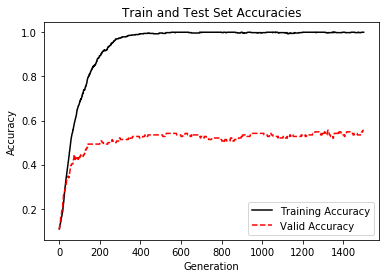

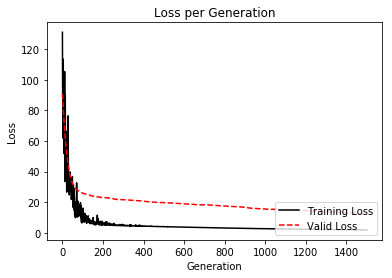

In [13]:
plt.plot(train_accuracy_best, 'k-', label='Training Accuracy')
plt.plot(valid_accuracy_best, 'r--', label='Valid Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(train_loss_best, 'k-',label='Training Loss')
plt.plot(valid_loss_best, 'r--', label='Valid Loss')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [14]:
def test(x_data,y_data,W):
    y_pred = x_data.dot(W)
    acc = np.mean(np.argmax(y_pred,1) == np.argmax(y_data,1))
    return acc*100;
accuracy=test(x_test,y_test,W_best)
print(accuracy)

53.04878048780488


In [ ]:
batch_size = 30
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
delta = 1.0
regulation_rate = 8e-4
learning_rate=0.015
sess.run(tf.initialize_all_variables())
for i in range(1500):
    rand_index = np.random.choice(x_train.shape[0], size=batch_size)
    rand_x = x_train[rand_index]
    rand_y = y_train[rand_index,:]
    sess.run(train_step, feed_dict={x_data: rand_x, y_data: rand_y})

    tloss = sess.run(loss, feed_dict={x_data: rand_x, y_data: rand_y})
    train_loss.append(tloss)   
    
    train_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_train,
        y_data: y_train})
    train_accuracy.append(train_acc_temp)

    Weight = sess.run(W)
    vloss = sess.run(loss, feed_dict={x_data: x_valid, y_data: y_valid,W:Weight})
    valid_loss.append(vloss)
    
    valid_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_valid,
        y_data: y_valid,W:Weight})
    valid_accuracy.append(valid_acc_temp)

    if ((i+1) % 100 == 1):
#         print('Step #{} W = {}'.format(
#             str(i+1),
#             str(sess.run(W)),
#         ))
        print('i: '+str(i)+ ' - Loss_train: '+ str(tloss) +' - Acc_train: ' 
              + str(train_acc_temp)+' - Loss_valid: '+str(vloss) + ' - Acc_valid: '+str(valid_acc_temp))


In [ ]:
sess = tf.Session()
#feature_size = x_train.shape[1]
delta = 1.0
regulation_rate = 8e-4
x_data = tf.placeholder(shape=[None,x_train.shape[1]], dtype=tf.float32)
y_data = tf.placeholder(shape=[None,y_train.shape[1]], dtype=tf.float32)
W = tf.Variable(tf.random_normal(shape=[x_train.shape[1], y_train.shape[1]]))

def svm_loss(x_data,y_data,W,regulation_rate):
    # graph = tf.Graph()
    # with graph.as_default():
    predict = tf.matmul(x_data,W)
    y = tf.reduce_sum(predict*y_data, 1, keep_dims=True)
    #loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, delta - y + predict),1))-delta
    loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, delta - y + predict),1))
    loss = tf.add(loss,regulation_rate * tf.nn.l2_loss(W))
 
    return loss

def accuracy(x_data,y_data,W):
    predict = tf.matmul(x_data,W)
    prediction = tf.argmax(predict,1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_data,1)), tf.float32))
    return accuracy*100;

def svm_multi_class(x_data,y_data,Winit,reg,lr=8e-4,batch_size = 100, num_iters = 1500):
    W = Winit
    my_opt = tf.train.AdamOptimizer(lr)
    train_step = my_opt.minimize(loss)
    for i in range(num_iters):
        rand_index = np.random.choice(x_data.shape[0], size=batch_size)
        rand_x = x_data[rand_index]
        rand_y = y_data[rand_index,:]
        sess.run(train_step, feed_dict={x_data: rand_x, y_data: rand_y})

        tloss = sess.run(svm_loss, feed_dict={x_data: rand_x, y_data: rand_y,regulation_rate=lr})
        train_loss.append(tloss)

        Weight = sess.run(W)
        vloss = sess.run(loss, feed_dict={x_data: x_valid, y_data: y_valid,W:Weight})
        valid_loss.append(vloss)
    
        train_acc_temp = sess.run(accuracy, feed_dict={
            x_data: x_train,
            y_data: y_train})
        train_accuracy.append(train_acc_temp)

        valid_acc_temp = sess.run(accuracy, feed_dict={
            x_data: x_valid,
            y_data: y_valid})
        valid_accuracy.append(valid_acc_temp)
    return W,train_loss,train_accuracy,valid_loss,valid_accuracy    
    


In [ ]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])
feature_size = x_train.shape[1]
num_labels=10
delta = 1.0
regulation_rate = 5e-4
graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.constant(x_train,dtype=tf.float32)
    tf_train_labels = tf.constant(y_train,dtype=tf.float32)
    
    weights = tf.Variable(tf.truncated_normal([feature_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    logits = tf.matmul(tf_train_dataset, weights) + biases
    # TODO better way as numpy's: np.choose(data.target, logits.T)
    y = tf.reduce_sum(logits * tf_train_labels, 1, keep_dims=True)
    loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, logits - y + delta), 1)) - delta
    loss += regulation_rate * tf.nn.l2_loss(weights)

    optimizer = tf.train.AdamOptimizer(0.1).minimize(loss)
    train_prediction = tf.nn.softmax(logits)
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(10001):
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if step % 500 == 0:
            print('step:{} loss:{:.6f} accuracy: {:.2f}'.format(
                    step, l, accuracy(predictions, y_train)))